---
title: PRISM Algorithm
authors: [gvarnavides]
date: 2025-01-26
---

In [1]:
%matplotlib widget
import py4DSTEM
import abtem
import ase

import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

abtem.config.set({"dask.lazy":False});

## Converged Probe Expansion

In [2]:
# parameters
gpts = np.array([128,128])
sampling = np.array([0.125,0.125])
extent = gpts*sampling
energy = 300e3
semiangle_cutoff = 20
defocus = 100

In [3]:
arrays_mutated = [
    None, # s_matrix
    None, # spiral_ordering
    None, # indices_i
    None, # indices_j
    None, # pos_px
    None, # position_coefs
    None, # defocus
    None, # ctf_coefs
]

In [4]:
# inputs a

interpolation_factor = 1

In [5]:
dummy_s_matrix = abtem.SMatrix(
    potential=None,
    sampling=sampling,
    gpts=gpts,
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    downsample=None,
    interpolation=interpolation_factor,
).build(
)

arrays_mutated[0] = dummy_s_matrix

In [6]:
def return_ordering_indices(s_matrix):
    wave_vectors = s_matrix.wave_vectors
    spiral_ordering = np.argsort(np.sum(wave_vectors**2,1))
    
    indices_i, indices_j = np.mod(
        (wave_vectors * s_matrix.extent).astype("int"),
        s_matrix.gpts
    ).T

    return spiral_ordering, indices_i, indices_j

arrays_mutated[1:4] = return_ordering_indices(arrays_mutated[0])

In [7]:
# inputs b

defocus = 100
pos_px = gpts/2

In [8]:
def return_position_coefs(s_matrix, pos_px):
    pos = (pos_px-gpts/2) * np.array(s_matrix.sampling)
    position_coefs = s_matrix._calculate_positions_coefficients(
        abtem.scan.CustomScan(pos),
    )[0]
    return position_coefs

def return_ctf_coefs(s_matrix, defocus):
    ctf_coefs = s_matrix._calculate_ctf_coefficients(
        ctf=abtem.CTF(
            defocus=defocus,
            semiangle_cutoff=np.inf,
            energy=energy
        )
    )
    return ctf_coefs

arrays_mutated[4] = pos_px
arrays_mutated[5] = return_position_coefs(arrays_mutated[0],arrays_mutated[4])

arrays_mutated[6] = defocus
arrays_mutated[7] = return_ctf_coefs(arrays_mutated[0],arrays_mutated[6])

In [9]:
# inputs c 

num_planewaves = 5

In [10]:
def return_selected_inds(
    num_planewaves,
    spiral_ordering,
    indices_i,
    indices_j,
):
    inds = spiral_ordering[:num_planewaves]
    inds_i = indices_i[inds]
    inds_j = indices_j[inds]
    return inds, inds_i, inds_j 

def return_arrays(
    s_matrix,
    inds,
    inds_i,
    inds_j,
    position_coefs,
    ctf_coefs,
):
    coefs = ctf_coefs[inds] * position_coefs[inds]
    beams = np.zeros(s_matrix.gpts,dtype=np.complex64)
    beams[inds_i,inds_j]= coefs
    scaled_beams = s_matrix.array[inds] * coefs[:,None,None]
    probe = scaled_beams.sum(0)
    return beams, scaled_beams, probe

inds, inds_i, inds_j = return_selected_inds(
    num_planewaves,
    arrays_mutated[1],
    arrays_mutated[2],
    arrays_mutated[3]
)

beams, scaled_beams, probe = return_arrays(
    arrays_mutated[0],
    inds,
    inds_i,
    inds_j,
    arrays_mutated[5],
    arrays_mutated[7]
)

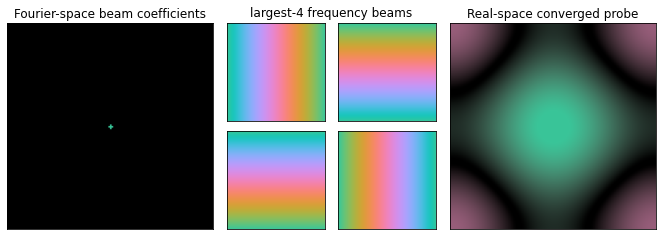

In [11]:
dpi=72
with plt.ioff():
    fig = plt.figure(figsize=(675/dpi,235/dpi),dpi=dpi)
    
spec = GridSpec(2,6,figure=fig)
ax1 = fig.add_subplot(spec[:,:2])
ax2a = fig.add_subplot(spec[0,2])
ax2b = fig.add_subplot(spec[0,3])
ax2c = fig.add_subplot(spec[1,2])
ax2d = fig.add_subplot(spec[1,3])
ax3 = fig.add_subplot(spec[:,4:])

beams_rgb = py4DSTEM.visualize.Complex2RGB(
    np.fft.fftshift(beams),
    vmin=0,vmax=1
)
im_beams = ax1.imshow(beams_rgb)
ax1.set_title("Fourier-space beam coefficients")

plane_tgb_tl = py4DSTEM.visualize.Complex2RGB(scaled_beams[np.maximum(-num_planewaves,-4)])
im_plane_tl = ax2a.imshow(plane_tgb_tl)

if num_planewaves > 1:
    plane_tgb_tr = py4DSTEM.visualize.Complex2RGB(scaled_beams[np.maximum(-num_planewaves+1,-3)])
    im_plane_tr = ax2b.imshow(plane_tgb_tr)
else:
    im_plane_tr = ax2b.imshow(np.ones_like(plane_tgb_tl))
    ax2b.set_visible(False)

if num_planewaves > 2:
    plane_tgb_bl = py4DSTEM.visualize.Complex2RGB(scaled_beams[np.maximum(-num_planewaves+2,-2)])
    im_plane_bl = ax2c.imshow(plane_tgb_bl)
else:
    im_plane_bl = ax2c.imshow(np.ones_like(plane_tgb_tl))
    ax2c.set_visible(False)

if num_planewaves > 3:
    plane_tgb_br = py4DSTEM.visualize.Complex2RGB(scaled_beams[np.maximum(-num_planewaves+3,-1)])
    im_plane_br = ax2d.imshow(plane_tgb_br)
else:
    im_plane_br = ax2d.imshow(np.ones_like(plane_tgb_tl))
    ax2d.set_visible(False)
        
fig.text(
    0.5,
    0.95,
    "largest-4 frequency beams",
    horizontalalignment="center",
    fontsize=12
)

probe_rgb = py4DSTEM.visualize.Complex2RGB(np.fft.fftshift(probe))
im_probe = ax3.imshow(probe_rgb)
ax3.set_title("Real-space converged probe")

for ax in fig.axes:
    ax.set(xticks=[],yticks=[])

fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = True
fig.canvas.layout.width = '675px'
fig.canvas.layout.height = '265px'
fig.canvas.toolbar_position = 'bottom'
spec.tight_layout(fig)
fig

In [12]:
layout = ipywidgets.Layout(width='330px',height='30px')
style = {
    'description_width': 'initial',
}

In [13]:
def update_num_planewaves(change):
    num_planewaves = change["new"]
    
    inds, inds_i, inds_j = return_selected_inds(
        num_planewaves,
        arrays_mutated[1],
        arrays_mutated[2],
        arrays_mutated[3]
    )
    
    beams, scaled_beams, probe = return_arrays(
        arrays_mutated[0],
        inds,inds_i,inds_j,
        arrays_mutated[5],
        arrays_mutated[7]
    )
    
    beams_rgb = py4DSTEM.visualize.Complex2RGB(
        np.fft.fftshift(beams),
        vmin=0,vmax=1
    )
    im_beams.set_data(beams_rgb)

    plane_tgb_tl = py4DSTEM.visualize.Complex2RGB(scaled_beams[np.maximum(-num_planewaves,-4)])
    im_plane_tl.set_data(plane_tgb_tl)

    if num_planewaves > 1:
        plane_tgb_tr = py4DSTEM.visualize.Complex2RGB(scaled_beams[np.maximum(-num_planewaves+1,-3)])
        im_plane_tr.set_data(plane_tgb_tr)
        ax2b.set_visible(True)
    else:
        ax2b.set_visible(False)
    
    if num_planewaves > 2:
        plane_tgb_bl = py4DSTEM.visualize.Complex2RGB(scaled_beams[np.maximum(-num_planewaves+2,-2)])
        im_plane_bl.set_data(plane_tgb_bl)
        ax2c.set_visible(True)
    else:
        ax2c.set_visible(False)
    
    if num_planewaves > 3:
        plane_tgb_br = py4DSTEM.visualize.Complex2RGB(scaled_beams[np.maximum(-num_planewaves+3,-1)])
        im_plane_br.set_data(plane_tgb_br)
        ax2d.set_visible(True)
    else:
        ax2d.set_visible(False)


    probe_rgb = py4DSTEM.visualize.Complex2RGB(np.fft.fftshift(probe))
    im_probe.set_data(probe_rgb)
    
    fig.canvas.draw_idle()
    return None

play = ipywidgets.Play(
    value=5,
    min=1,
    max=len(arrays_mutated[0]),
    step=1,
    interval=25,
)

slider = ipywidgets.IntSlider(
    min=1,
    max=len(arrays_mutated[0]),
    step=1,
    layout=layout,
    style=style,
    description="# of beams"
)

ipywidgets.jslink((play, 'value'), (slider, 'value'))
slider.observe(update_num_planewaves,"value")

In [14]:
def update_interpolation_factor(change):
    interpolation_factor = change["new"]
    
    s_matrix = abtem.SMatrix(
        potential=None,
        sampling=sampling,
        gpts=gpts,
        energy=energy,
        semiangle_cutoff=semiangle_cutoff,
        downsample=None,
        interpolation=interpolation_factor,
    ).build(
    )
    
    arrays_mutated[0] = s_matrix
    arrays_mutated[1:4] = return_ordering_indices(arrays_mutated[0])
    arrays_mutated[5] = return_position_coefs(arrays_mutated[0],arrays_mutated[4])
    arrays_mutated[7] = return_ctf_coefs(arrays_mutated[0],arrays_mutated[6])
    
    slider.max = len(arrays_mutated[0])
    if slider.value < slider.max:
        update_num_planewaves({"new":slider.value})
    return None

def update_defocus(change):

    arrays_mutated[6] = change["new"]
    arrays_mutated[7] = return_ctf_coefs(arrays_mutated[0],arrays_mutated[6])
    update_num_planewaves({"new":slider.value})
  
    return None

interpolation_slider = ipywidgets.SelectionSlider(
    options=[1,2,4,8,16],
    value=1,
    description="interpolation factor",
    layout=layout,
    style=style,
)
interpolation_slider.observe(update_interpolation_factor,"value")

defocus_slider = ipywidgets.FloatSlider(
    min=-150,
    max=150,
    value=100,
    description="defocus [Å]",
    layout=layout,
    style=style,
)
defocus_slider.observe(update_defocus,"value")

def onclick(event):
    """ """
    positions_px = np.array([event.ydata,event.xdata])
    
    if positions_px[0] is not None:
        arrays_mutated[4] = positions_px
        arrays_mutated[5] = return_position_coefs(arrays_mutated[0],arrays_mutated[4])
        update_num_planewaves({"new":slider.value})

cid = fig.canvas.mpl_connect('button_press_event',onclick)

In [15]:
ipywidgets.VBox(
    [
        ipywidgets.HBox([slider,play]),
        ipywidgets.HBox([interpolation_slider,defocus_slider]),
        fig.canvas
    ]
)